# Support Vector Machines (SVM) & Kernel Trick - From Scratch (with SciPy Optimizer)

This unified tutorial is inspired by:
- Kaggle: *SVM with Kernel Trick from Scratch*
- GeeksforGeeks: *Implementing SVM and Kernel SVM with scikit-learn*
- MachineLearningMastery: *Kernel Methods in Python*
- QuarkML blog: *SVM kernels (polynomial, RBF)*

We will:

1. Implement the **dual formulation** of a soft-margin SVM using NumPy.
2. Use **SciPy's optimizer** to solve the dual problem (instead of writing SMO ourselves).
3. Implement the **kernel trick** via linear and RBF kernels.
4. Compare accuracy and decision boundaries of **linear vs RBF kernels** on `make_circles`.


## Learning objectives

By the end of this tutorial, you should be able to:

- Write down the soft-margin SVM **dual objective** and constraints.
- Implement **kernel functions** (linear, RBF) and Gram matrices in NumPy.
- Use **SciPy** to solve the constrained quadratic optimization problem for SVM.
- Visualize and compare linear vs RBF SVMs on a non-linearly separable dataset.


In [1]:
# PACKAGE: DO NOT EDIT THIS CELL
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from scipy.optimize import minimize

plt.rcParams['figure.figsize'] = (6, 4)
np.set_printoptions(precision=4, suppress=True)


## 1) Toy dataset: non-linear circles

We use `make_circles` so that:

- linear SVM fails to separate the classes well,
- RBF SVM succeeds thanks to the kernel trick.


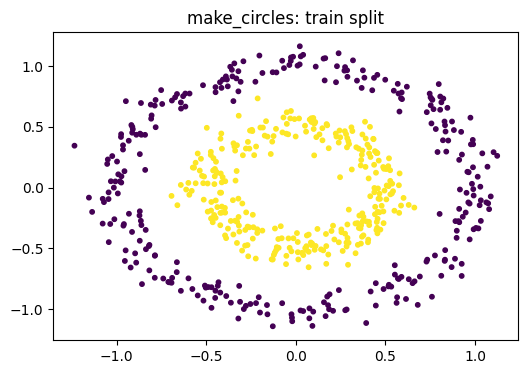

In [2]:
X, y = make_circles(n_samples=800, factor=0.5, noise=0.08, random_state=0)
y = np.where(y == 1, 1, -1)  # convert labels to {-1, +1}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10)
plt.title("make_circles: train split")
plt.show()


## 2) Kernels

Implement the **linear** and **RBF** kernels and a helper to compute the Gram matrix.

We will use:

- Linear:  \(K(x,z) = x^\top z\)
- RBF:     \(K(x,z) = \exp(-\gamma \|x - z\|^2)\)


In [3]:
def linear_kernel(X1, X2):
    """Return linear kernel Gram matrix K_ij = <x_i, z_j>."""
    return X1 @ X2.T


def rbf_kernel(X1, X2, gamma: float):
    """Return RBF kernel Gram matrix K_ij = exp(-gamma ||x_i - z_j||^2)."""
    X1_sq = np.sum(X1**2, axis=1)[:, None]      # shape (n1, 1)
    X2_sq = np.sum(X2**2, axis=1)[None, :]      # shape (1, n2)
    cross = X1 @ X2.T                           # shape (n1, n2)

    dists_sq = X1_sq + X2_sq - 2 * cross        # pairwise ||x_i - z_j||^2
    return np.exp(-gamma * dists_sq)


def compute_gram(X1, X2, kernel: str = "linear", gamma: float = 1.0):
    """Compute Gram matrix for the given kernel type."""
    if kernel == "linear":
        return linear_kernel(X1, X2)
    elif kernel == "rbf":
        return rbf_kernel(X1, X2, gamma)
    else:
        raise ValueError(f"Unknown kernel type: {kernel}")


## 3) Dual SVM with SciPy optimizer

We consider the soft-margin SVM dual:

\begin{align}
\max_{\alpha} \quad &
  \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i,j=1}^N \alpha_i \alpha_j y_i y_j K(x_i, x_j) \\
\text{s.t.} \quad & 0 \le \alpha_i \le C, \quad \forall i \\
                  & \sum_{i=1}^N \alpha_i y_i = 0
\end{align}

We will:

1. Precompute the **Gram matrix** \\(K\\).
2. Precompute \\(Q_{ij} = y_i y_j K_{ij}\\).
3. Define the **objective** to *minimize* (negative of the dual).
4. Use `scipy.optimize.minimize` with:
   - bounds `0 <= alpha_i <= C`,
   - equality constraint `sum(alpha_i * y_i) = 0`.


In [47]:
class SVMFromScratch:
    def __init__(self, C=1.0, kernel="linear", gamma=1.0, random_state=0):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.random_state = random_state

        self.X = None
        self.y = None
        self.alphas = None
        self.b = 0.0

    def fit(self, X, y):
        """Fit SVM by solving the dual with SciPy's optimizer."""
        self.X = X
        self.y = y.astype(float)
        N = X.shape[0]

        # Gram matrix
        K = compute_gram(X, X, kernel=self.kernel, gamma=self.gamma)
        # Q_ij = y_i y_j K_ij
        Q = (self.y[:, None] * self.y[None, :]) * K

        def objective(alpha):
            # 0.5 * alpha^T Q alpha - 1^T alpha  (to MINIMIZE)
            # alpha = alpha.reshape(-1, 1)
            # return 0.5 * float(alpha.T @ Q @ alpha) - float(alpha.sum())
            return 0.5 * alpha @ (Q @ alpha) - alpha.sum()

        def objective_grad(alpha):
            # gradient: Q alpha - 1
            # return (Q @ alpha) - np.ones_like(alpha)
            return (Q @ alpha) - np.ones_like(alpha)

        # Equality constraint: sum_i alpha_i y_i = 0
        constraints = ({
            "type": "eq",
            "fun": lambda a: np.dot(a, self.y),
            "jac": lambda a: self.y
        },)

        bounds = [(0, self.C) for _ in range(N)]
        alpha0 = np.zeros(N)

        res = minimize(
            fun=objective,
            x0=alpha0,
            jac=objective_grad,
            bounds=bounds,
            constraints=constraints,
            method="SLSQP",
            options={"maxiter": 500, "ftol": 1e-6, "disp": False},
        )

        self.alphas = res.x

        # Compute bias term b using support vectors with 0 < alpha_i < C
        sv_mask = (self.alphas > 1e-6) & (self.alphas < self.C - 1e-6)
        if not np.any(sv_mask):
            # Fallback: just use any non-zero alpha
            sv_mask = self.alphas > 1e-6

        idx = np.where(sv_mask)[0]
        if idx.size == 0:
            self.b = 0.0
        else:
            # b = y_i - sum_j alpha_j y_j K_ij, averaged over SVs
            b_vals = []
            for i in idx:
                s = np.sum(self.alphas * self.y * K[i])
                b_vals.append(self.y[i] - s)
            self.b = float(np.mean(b_vals))

        return self

    def decision_function(self, X_new):
        """Compute f(x) = sum_i alpha_i y_i K(x_i, x) + b."""

        # Грам-матриця між тренувальними та новими точками
        K_new = compute_gram(self.X, X_new, kernel=self.kernel, gamma=self.gamma)

        # Ваги = alpha_i * y_i
        w = self.alphas * self.y

        # f(x) = Σ (alpha_i y_i K(x_i, x)) + b
        return w @ K_new + self.b

    def predict(self, X_new):
        """Return predicted labels in {-1, +1}."""
        return np.sign(self.decision_function(X_new))


## 4) Train & compare: Linear vs RBF on `make_circles`

Now we:

1. Train **linear SVM** and evaluate on test set.
2. Train **RBF SVM** and evaluate on test set.
3. Plot decision boundaries for both.


In [5]:
def plot_decision_boundary(model, X, y, title="Decision boundary"):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2, levels=[-1, 0, 1])
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
    plt.title(title)
    plt.show()


Linear kernel accuracy: 0.510


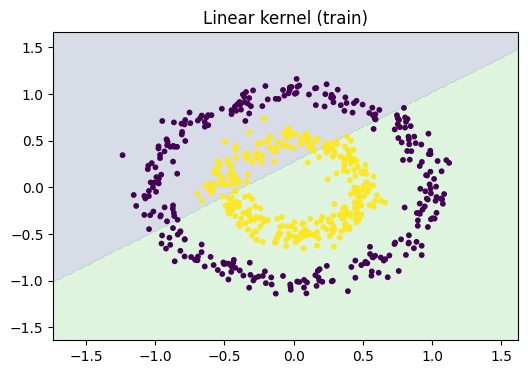

In [6]:
# Train and evaluate linear SVM
svm_lin = SVMFromScratch(C=1.0, kernel="linear").fit(X_train, y_train)
y_pred_lin = svm_lin.predict(X_test)
acc_lin = accuracy_score(y_test, y_pred_lin)
print(f"Linear kernel accuracy: {acc_lin:.3f}")
plot_decision_boundary(svm_lin, X_train, y_train, title="Linear kernel (train)")

RBF kernel accuracy: 1.000


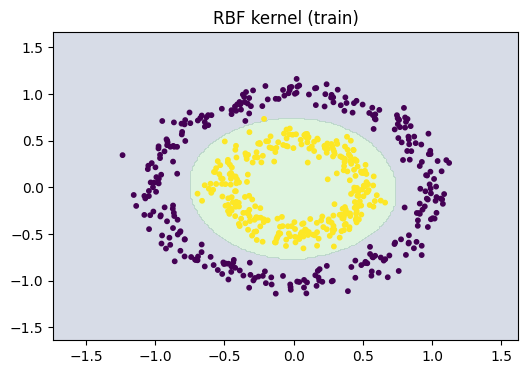

In [7]:
# Train and evaluate RBF SVM (e.g., gamma=2.0)
svm_rbf = SVMFromScratch(C=1.0, kernel="rbf", gamma=2.0).fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"RBF kernel accuracy: {acc_rbf:.3f}")
plot_decision_boundary(svm_rbf, X_train, y_train, title="RBF kernel (train)")

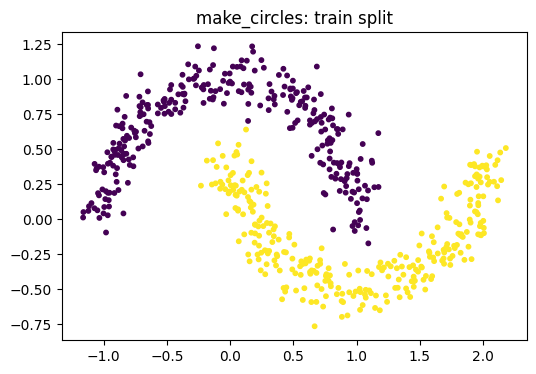

In [8]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples= 800, noise= 0.1, random_state= 42)
y = np.where(y == 1, 1, -1)  # convert labels to {-1, +1}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10)
plt.title("make_circles: train split")
plt.show()

RBF kernel accuracy: 1.000


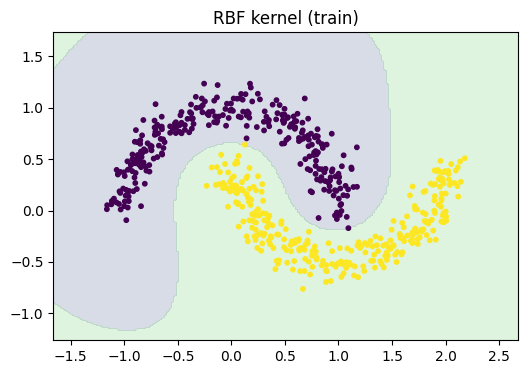

In [9]:
# Train and evaluate RBF SVM (e.g., gamma=2.0)
svm_rbf = SVMFromScratch(C=1.0, kernel="rbf", gamma=2.0).fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"RBF kernel accuracy: {acc_rbf:.3f}")
plot_decision_boundary(svm_rbf, X_train, y_train, title="RBF kernel (train)")

# Застосування SVM with Kernel Trick для реальних даних

https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction - джерело даних

The bank customer churn dataset – поширений набір даних для прогнозування відтоку клієнтів у банківській галузі. Він містить інформацію про клієнтів банку, які або залишили банк, або продовжують бути його клієнтами. Набір даних включає такі атрибути:


- Customer ID: Унікальний ідентифікатор кожного клієнта
- Surname: Прізвище клієнта
- Credit Score: Числове значення, що відображає кредитний рейтинг клієнта
- Geography: Країна проживання клієнта (Франція, Іспанія або Німеччина)
- Gender: Стать клієнта (Чоловік або Жінка)
- Age: Вік клієнта
- Tenure: Кількість років, протягом яких клієнт обслуговується в банку
- Balance: Баланс на рахунку клієнта
- NumOfProducts: Кількість банківських продуктів, якими користується клієнт (наприклад, ощадний рахунок, кредитна картка)
- HasCrCard: Наявність кредитної картки у клієнта (1 = так, 0 = ні)
- IsActiveMember: Чи є клієнт активним учасником (1 = так, 0 = ні)
- EstimatedSalary: Оцінка заробітної плати клієнта
- Exited: Чи залишив клієнт банк (1 = так, 0 = ні)

## Завантаження бібліотек та даних

In [10]:
import numpy as np
import pandas as pd
import random
random.seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
#from process_bank_churn import preprocess_data
#from ml_utils import auroc_train_and_val, predict_and_plot

In [11]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/OlenaKirieva/Genetic_tree_optimizer/refs/heads/main/bank-customer-churn-prediction.csv', index_col = 'id')
raw_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [12]:
df = raw_df.drop(['CustomerId', 'Surname'], axis = 1).copy()

## Перевірка на наявність дублікатів та пропущених значень

In [61]:
print('Кількість дублікатів в даних', df.duplicated().sum())
print('Пропущених значень в даних', df.isna().values.sum())

Кількість дублікатів в даних 0
Пропущених значень в даних 0


## Розподіл цільової змінної

In [15]:
def target_distribution(df, y):
  plt.rcParams['figure.figsize']=15,5
  plt.subplot(121)
  plt.title('Checking balance of target', fontsize=10)
  s = sns.countplot(x=y, data=df, alpha=0.7)
  for p in s.patches:
      s.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center',
                  xytext = (0, 4),
                  textcoords = 'offset points')


  ax = plt.subplot(122)
  mush_classpie = df[y].value_counts()
  mush_size = mush_classpie.values.tolist()
  mush_types = mush_classpie.axes[0].tolist()
  mush_labels = '0', '1'
  colors = ['lightskyblue', '#00FFFF']
  plt.title('Subscribed Status In Percentange', fontsize=10)
  patches, texts, autotexts = plt.pie(mush_size, labels=mush_labels,  colors=colors,
          autopct='%1.1f%%',  startangle=150)
  plt.axis('equal')
  plt.show();

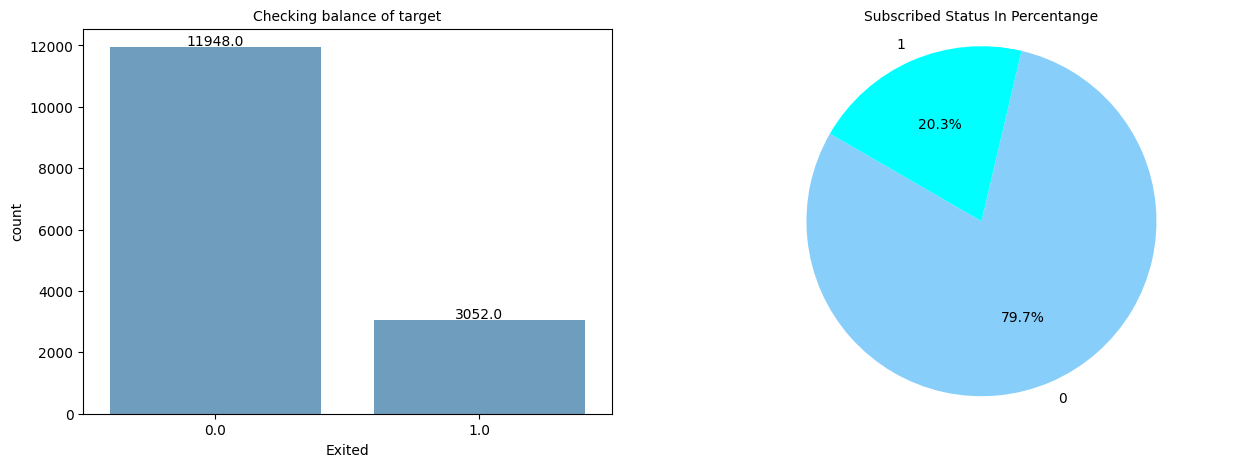

In [16]:
target_distribution(df, 'Exited')

Розподіл цільової змінної "0" - 79.7%, "1" - 20.3%, майже 5:1, свідчить про незбалансованість класів. Переважна більшість клієнтів залишається клієнтами банку. Також хотілося б відслідковувати, які саме клієнти покидають банк. Це важливо враховувати при побудові моделі та слід розглянути підходи, які працюють для незбалансованих даних:
*   Oversampling (збільшення кількості "yes" спостережень),
*   Undersampling (зменшення кількості "no" спостережень).

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      15000 non-null  float64
 1   Geography        15000 non-null  object 
 2   Gender           15000 non-null  object 
 3   Age              15000 non-null  float64
 4   Tenure           15000 non-null  float64
 5   Balance          15000 non-null  float64
 6   NumOfProducts    15000 non-null  float64
 7   HasCrCard        15000 non-null  float64
 8   IsActiveMember   15000 non-null  float64
 9   EstimatedSalary  15000 non-null  float64
 10  Exited           15000 non-null  float64
dtypes: float64(9), object(2)
memory usage: 1.4+ MB


In [18]:
# Виділення числових та категоріальних колонок
numeric_cols = df.select_dtypes(include='number').columns.tolist()[:-1]
categor_cols = df.select_dtypes(include='object').columns.tolist()
print('Кількість числових колонок:', len(numeric_cols))
print('Кількість категоріальних колонок:', len(categor_cols))

Кількість числових колонок: 8
Кількість категоріальних колонок: 2


## Матриця кореляції

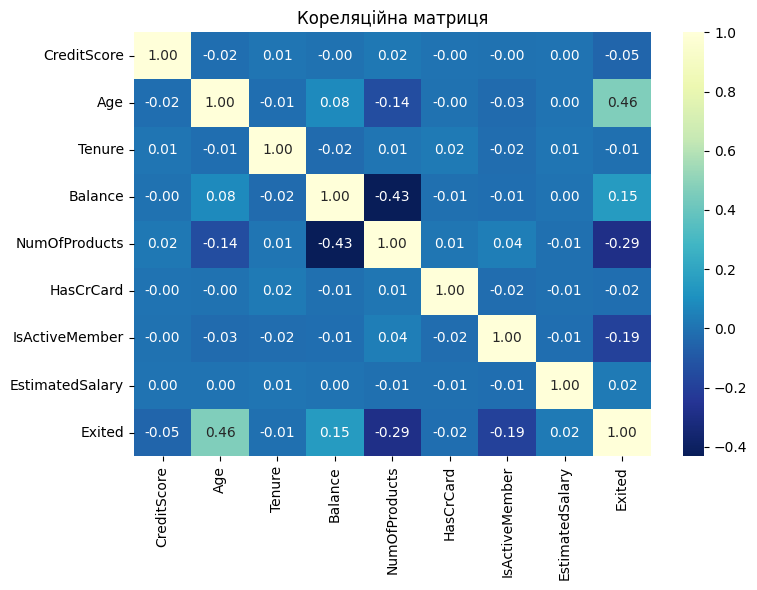

In [19]:
# Вибір числових стовбців для побудови кореляційної матриці
corr_cols = df.select_dtypes(include='number').columns

# Теплова карта кореляційної матриці
plt.figure(figsize=(8, 6)) # Розмір графіка: ширина=10, висота=8
sns.heatmap(
    df[corr_cols].corr(),
    annot=True,             # показувати значення
    fmt=".2f",              # два знаки після коми
    cmap="YlGnBu_r")        # колірна гама: Yellow-Green-Blue
plt.title("Кореляційна матриця")
plt.tight_layout()
plt.show()

In [20]:
df.describe(percentiles = [0, 0.03, 0.25, 0.75, 0.98, 1]).round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.0
mean,658.94,37.74,5.03,42729.79,1.59,0.79,0.49,117784.67,0.2
std,72.26,8.22,2.78,59727.31,0.53,0.41,0.50,45734.45,0.4
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
0%,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
3%,528.00,25.00,1.00,0.00,1.00,0.00,0.00,25684.46,0.0
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83058.14,0.0
50%,662.00,37.00,5.00,0.00,2.00,1.00,0.00,123584.87,0.0
75%,708.00,42.00,7.00,109531.02,2.00,1.00,1.00,156884.70,0.0
98%,824.00,59.00,10.00,157777.65,2.00,1.00,1.00,185599.12,1.0


**Спостереження:**

Згідно матриці кореляції:

- позитивна кореляція 0.46 цільової змінної з "Age" - віком клієнта;

- слабенька негативна кореляція -0.29 цільової змінної з "NumOfProducts" - кількістю банківських продуктів, яким користується клієнт.

Статистичний опис показує:
-  наявність викидів в категоріях "Age", "Balance";
-  великі значення стандіртного відхилення для "Balance" i "EstimatedSalary", що може впливати на роботу алгоритма.

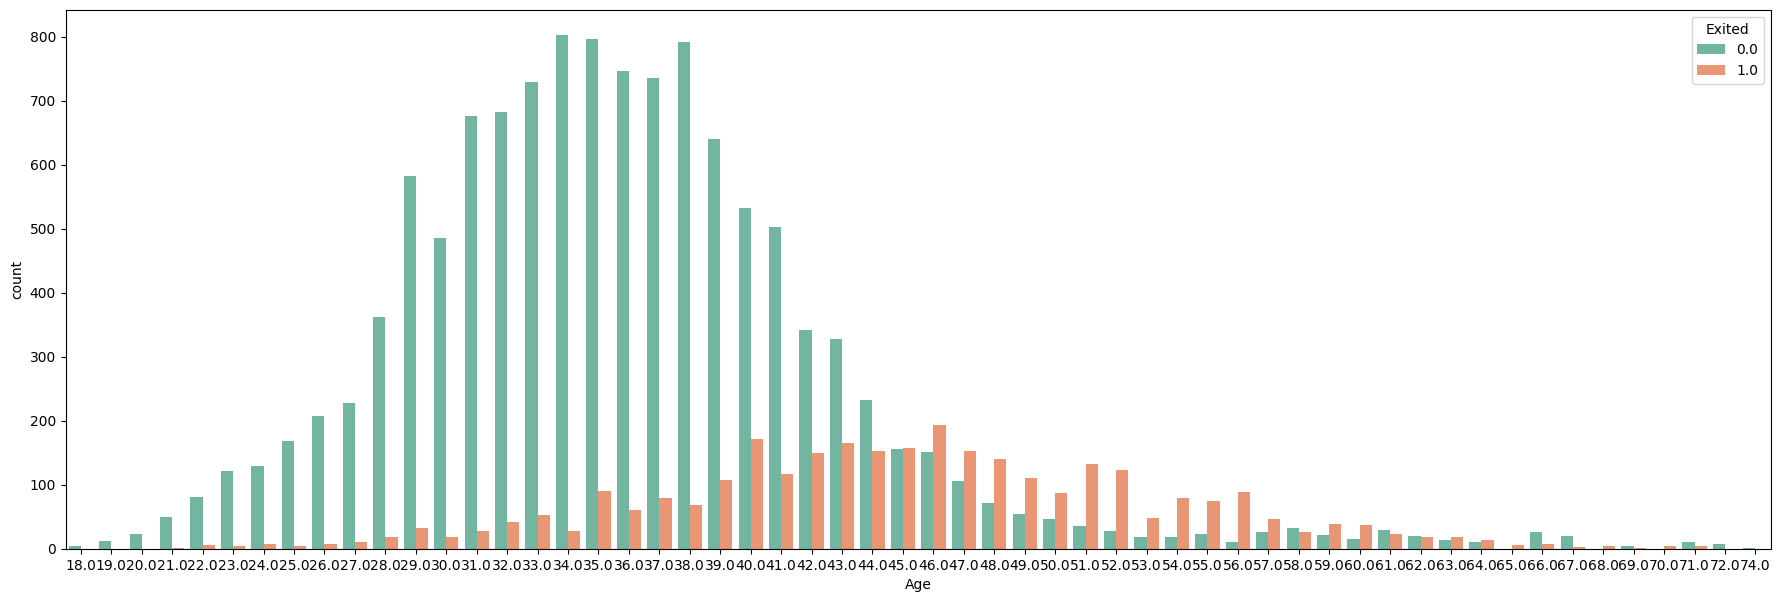

In [21]:
plt.figure(figsize=(22, 7))
sns.countplot(x='Age', hue='Exited', data=df, palette='Set2')
plt.show();

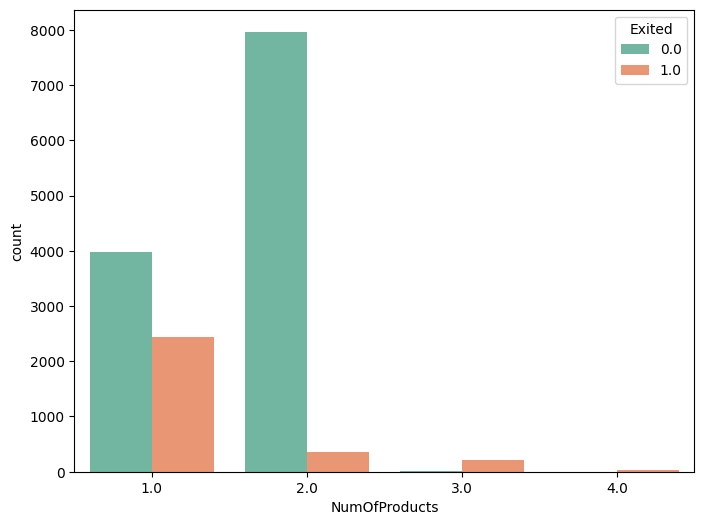

In [22]:
plt.figure(figsize=(8, 6))
sns.countplot(x='NumOfProducts', hue='Exited', data=df, palette='Set2')
plt.show();

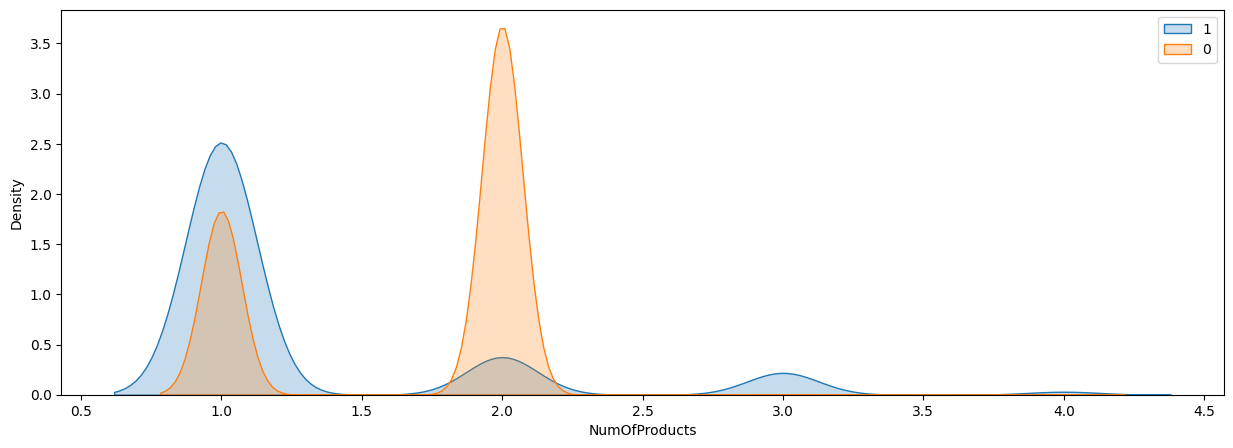

In [23]:
sns.kdeplot(data=df[df['Exited'] == 1], x='NumOfProducts', label='1', fill=True)
sns.kdeplot(data=df[df['Exited'] == 0], x='NumOfProducts', label='0', fill=True)
plt.legend()
plt.show()

## Аналіз категоріальних ознак

In [24]:
frames = []

for column in categor_cols:
    unique_values = df[column].unique()
    # Create a DataFrame for each column's unique values
    temp_df = pd.DataFrame({'Column Name': column, 'Unique Values': [unique_values], 'Count Unique Values': len(unique_values)})
    frames.append(temp_df)

# Concatenate all DataFrames in the list
unique_values_df = pd.concat(frames, ignore_index=True)
pd.set_option('display.max_colwidth', None)

display(unique_values_df)

,Column Name,Unique Values,Count Unique Values
0,Geography,"[France, Germany, Spain]",3
1,Gender,"[Male, Female]",2


In [25]:
def categor_plots(df, col, y):
  # Create a figure with two subplots in one row
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

  #  First plot: barplot
  #col = 'education'
  sns.barplot(
      x=col,
      y=y,
      data=df,
      estimator=np.mean,
      hue=col,
      dodge=False,
      palette='Set2',
      legend=False,
      ax=axes[0]
  )
  axes[0].set_ylabel('Class 1 probability')

  # FIX: Get both tick positions and labels and then set them
  tick_positions = axes[0].get_xticks()
  labels_to_rotate = [l.get_text() for l in axes[0].get_xticklabels()]

  axes[0].set_xticks(tick_positions)
  axes[0].set_xticklabels(labels_to_rotate, rotation=45)

  axes[0].set_title(f'Share of target variable by category {col}')

  #  Second plot: countplot
  sns.countplot(
      x=col,
      hue= y,
      data=df,
      ax=axes[1],
      palette='Set2'
  )
  axes[1].set_title(f'Distribution of {col}')
  axes[1].set_xlabel(col)
  axes[1].set_ylabel('Count')
  axes[1].legend(title='Subscribed to Term Deposit', loc='upper right')
  axes[1].tick_params(axis='x', rotation=45)

  # Adjust plot spacing
  plt.tight_layout()

  # Show the combined figure
  plt.show()

In [26]:
def categor_table_report(df, col, y):
    # Таблиця з кількістю
    counts_table = pd.crosstab(df[col], df[y])

    # Таблиця з відсотками
    percentage_table = pd.crosstab(df[col], df[y], normalize='index') * 100
    percentage_table = percentage_table.round(0)

    # Автоматичне перейменування колонок
    percentage_table = percentage_table.rename(
        columns={val: f"{val}_pct" for val in percentage_table.columns}
    )

    # З'єднання таблиць
    combined_table = counts_table.join(percentage_table)

    display(combined_table.sort_values(
        by=[col for col in combined_table.columns if str(col).endswith('_pct')][-1],
        ascending=False
    ))

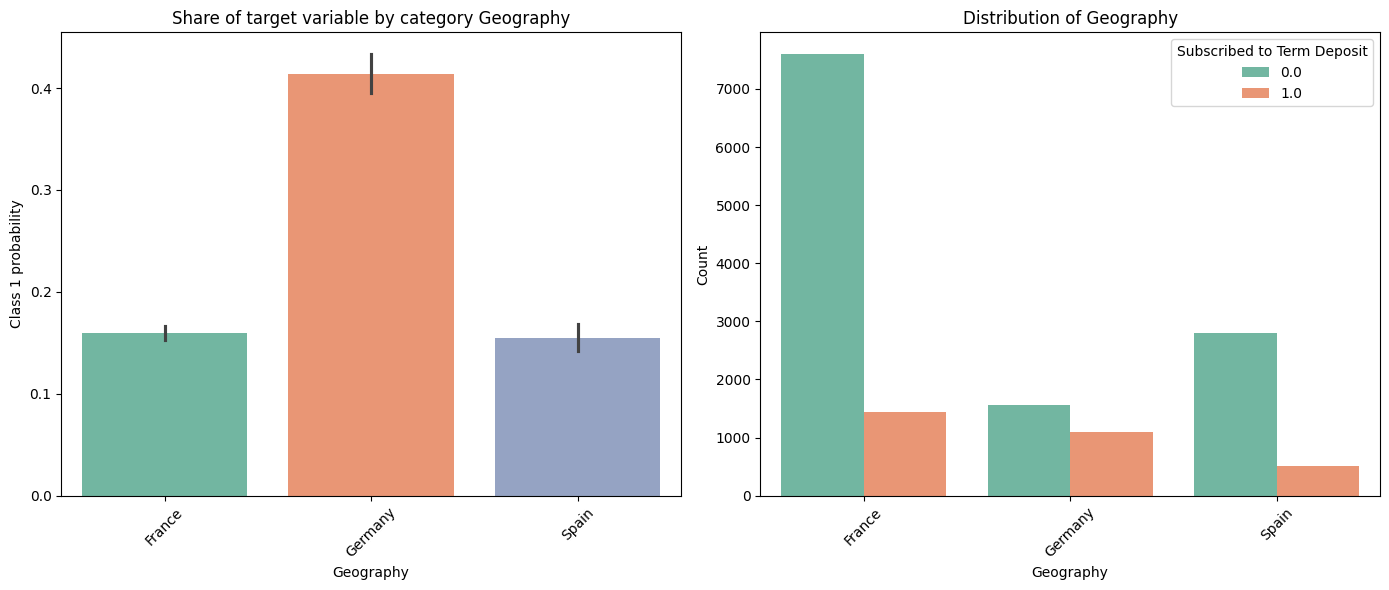

Exited,0.0,1.0,0.0_pct,1.0_pct
Geography,,,,
Germany,1563,1102,59.0,41.0
France,7594,1438,84.0,16.0
Spain,2791,512,84.0,16.0


In [27]:
categor_plots(df, 'Geography', 'Exited')
categor_table_report(df, 'Geography', 'Exited')

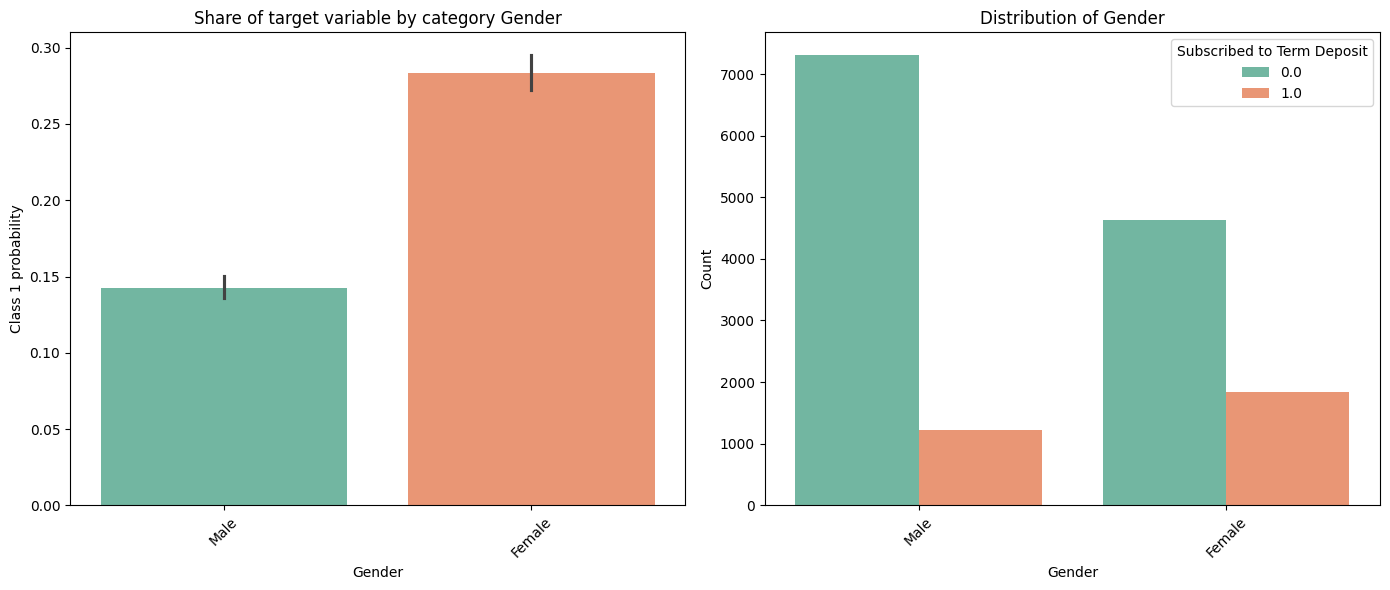

Exited,0.0,1.0,0.0_pct,1.0_pct
Gender,,,,
Female,4636,1835,72.0,28.0
Male,7312,1217,86.0,14.0


In [28]:
categor_plots(df, 'Gender', 'Exited')
categor_table_report(df, 'Gender', 'Exited')

## Аналіз даних на викиди

In [29]:
def remove_outliers_iqr(df, column, n = 1.5, remove = False):
    """
    Виявляє та видаляє (remove = Ture) викиди зі вказаного стовпця DataFrame
    за допомогою методу міжквартильного розмаху (IQR).

    Параметри:
    - df (pd.DataFrame): Вхідний DataFrame.
    - column (str): Назва стовпця, в якому шукати викиди.
    - n: коефіцієнт міжквартильного розмаху.
    - remove: видаляти чи ні спостереження з викидами.

    Повертає:
    - pd.DataFrame: DataFrame без викидів, якщо викиди видаляються.

    """
    print(df[column].min(), '<=', column, '<=', df[column].max())

    # Обчислення Q1, Q3 та IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Визначення меж для викидів
    lower_bound = Q1 - n * IQR
    upper_bound = Q3 + n * IQR

    print("Визначення меж для викидів")
    print(f'Q1 - {n} * IQR =', lower_bound)
    print(f'Q3 + {n} * IQR =', upper_bound, '\n')

    # Виявлення викидів
    outliers_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    outliers_df = df[outliers_mask]

    if remove:
      df_no_outliers = df[~outliers_mask]
      print(f"Зі стовпця '{column}' видалено {len(outliers_df)} викидів.")
      return df_no_outliers, outliers_df

In [30]:
# Визначення колонок, які можуть містити викиди
columns_to_check = [*numeric_cols]
for col in columns_to_check:
  print(f'Для змінної  {col}')
  remove_outliers_iqr(df, col, n = 1.5, remove = False)

Для змінної  CreditScore
431.0 <= CreditScore <= 850.0
Визначення меж для викидів
Q1 - 1.5 * IQR = 445.5
Q3 + 1.5 * IQR = 865.5 

Для змінної  Age
18.0 <= Age <= 74.0
Визначення меж для викидів
Q1 - 1.5 * IQR = 17.0
Q3 + 1.5 * IQR = 57.0 

Для змінної  Tenure
0.0 <= Tenure <= 10.0
Визначення меж для викидів
Q1 - 1.5 * IQR = -3.0
Q3 + 1.5 * IQR = 13.0 

Для змінної  Balance
0.0 <= Balance <= 209767.31
Визначення меж для викидів
Q1 - 1.5 * IQR = -164296.52625
Q3 + 1.5 * IQR = 273827.54375 

Для змінної  NumOfProducts
1.0 <= NumOfProducts <= 4.0
Визначення меж для викидів
Q1 - 1.5 * IQR = -0.5
Q3 + 1.5 * IQR = 3.5 

Для змінної  HasCrCard
0.0 <= HasCrCard <= 1.0
Визначення меж для викидів
Q1 - 1.5 * IQR = 1.0
Q3 + 1.5 * IQR = 1.0 

Для змінної  IsActiveMember
0.0 <= IsActiveMember <= 1.0
Визначення меж для викидів
Q1 - 1.5 * IQR = -1.5
Q3 + 1.5 * IQR = 2.5 

Для змінної  EstimatedSalary
11.58 <= EstimatedSalary <= 199992.48
Визначення меж для викидів
Q1 - 1.5 * IQR = -27681.707499999975
Q

**Спостереження:**

Викиди є тільки для ознаки "Age", але оскільки це єдина ознака для якої прослідковується помітна позитивна кореляція з цільовою змінною варто залишити все без змін.

## Preprocessing

In [31]:
X = df.drop('Exited', axis = 1)
y = df.Exited

In [32]:
y = np.where(y == 1, 1, -1)

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      15000 non-null  float64
 1   Geography        15000 non-null  object 
 2   Gender           15000 non-null  object 
 3   Age              15000 non-null  float64
 4   Tenure           15000 non-null  float64
 5   Balance          15000 non-null  float64
 6   NumOfProducts    15000 non-null  float64
 7   HasCrCard        15000 non-null  float64
 8   IsActiveMember   15000 non-null  float64
 9   EstimatedSalary  15000 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.3+ MB


In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state=42)
print('train_df.shape :', X_train.shape)
print('test_df.shape :', X_test.shape)

train_df.shape : (12000, 10)
test_df.shape : (3000, 10)


In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categor_cols),
    ('num', StandardScaler(), numeric_cols)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

In [36]:
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix

def metrics(model, X, y):
  y_pred = model.predict(X)
  f1 = f1_score(y, y_pred, pos_label=1)
  print(f"F1-Score: {f1:.3f}")

  print("\n Classification Report")
  print(classification_report(y, y_pred))

  # Обчислюємо матрицю
  cm = confusion_matrix(y, y_pred, normalize='true')

  # Візуалізація
  plt.figure(figsize=(6,4))
  sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
              xticklabels=["Не пішов (0)", "Пішов (1)"],
              yticklabels=["Не пішов (0)", "Пішов (1)"])
  plt.xlabel("Прогноз")
  plt.ylabel("Реальність")
  plt.title("Confusion Matrix (Heatmap)")
  plt.show()

## Навчання моделей

Detailed Metrics
Train
F1-Score: 0.894

 Classification Report
              precision    recall  f1-score   support

          -1       0.96      0.99      0.98       796
           1       0.98      0.82      0.89       204

    accuracy                           0.96      1000
   macro avg       0.97      0.91      0.93      1000
weighted avg       0.96      0.96      0.96      1000



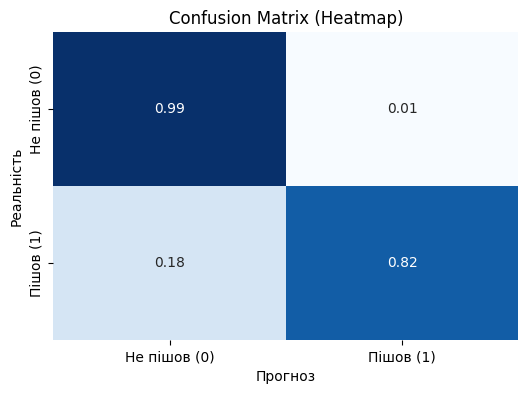

Test
F1-Score: 0.481

 Classification Report
              precision    recall  f1-score   support

          -1       0.85      0.97      0.91      2390
           1       0.78      0.35      0.48       610

    accuracy                           0.85      3000
   macro avg       0.82      0.66      0.70      3000
weighted avg       0.84      0.85      0.82      3000



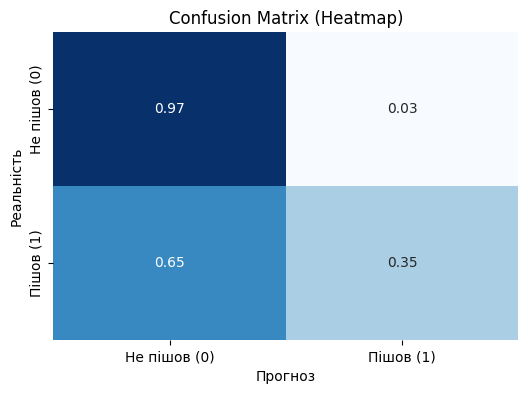

In [37]:
from sklearn.utils import resample
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix

# Об'єднуємо X та y, щоб перемішати їх разом
X_sample, y_sample = resample(X_train_proc, y_train,
                              n_samples=1000,
                              replace=False,
                              stratify=y_train, # Зберігаємо пропорцію класів!
                              random_state=42)

# створюємо та навчаємо модель
svm_custom = SVMFromScratch(C=1.0, kernel="rbf", gamma=0.5)

# Передаємо підготовлені  значення
svm_custom.fit(X_sample, y_sample)

print("Detailed Metrics")

print("Train")
metrics(svm_custom, X_sample, y_sample)

print("Test")
metrics(svm_custom, X_test_proc, y_test)

**Спостереження:**

Оскільки дана модель може працювати тільки з невеликим числом даних, довелося вибрати частину: 1000 екземплярів з 12000. Метрики показують на перенавчання і така модель погано узагальнуює.

Можна спробувати підібрати гіперпараметри.

Detailed Metrics
Train
F1-Score: 0.566

 Classification Report
              precision    recall  f1-score   support

          -1       0.87      0.99      0.92       796
           1       0.90      0.41      0.57       204

    accuracy                           0.87      1000
   macro avg       0.89      0.70      0.74      1000
weighted avg       0.87      0.87      0.85      1000



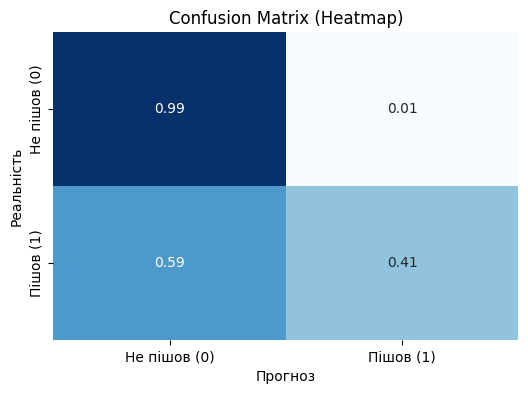

Test
F1-Score: 0.539

 Classification Report
              precision    recall  f1-score   support

          -1       0.86      0.98      0.92      2390
           1       0.84      0.40      0.54       610

    accuracy                           0.86      3000
   macro avg       0.85      0.69      0.73      3000
weighted avg       0.86      0.86      0.84      3000



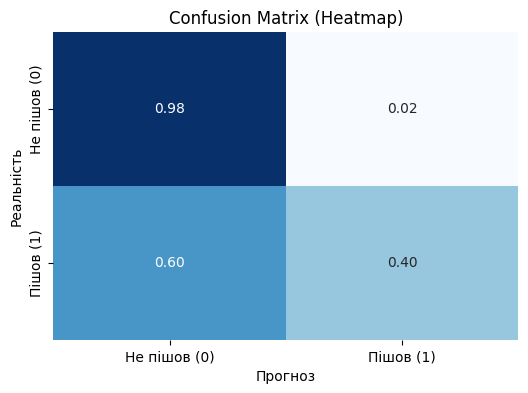

In [50]:
# створюємо та навчаємо модель
svm_custom = SVMFromScratch(C=0.3, kernel="rbf", gamma=0.1)

# Передаємо підготовлені  значення
svm_custom.fit(X_sample, y_sample)

print("Detailed Metrics")

print("Train")
metrics(svm_custom, X_sample, y_sample)

print("Test")
metrics(svm_custom, X_test_proc, y_test)

**Спостереження**

З параметрами C=0.3 і gamma=0.1 модель краще узагальнює, але 40% правильних значень для класу 1 це дуже слабенький результат.

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# Визначаємо простір параметрів
param_dist = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.01, 0.1, 0.5, 1, 10]
}

# Модель
svm = SVC(kernel="rbf")

# RandomizedSearchCV: n_iter = кількість випадкових комбінацій
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=10,              # скільки випадкових комбінацій перевірити
    cv=5,
    scoring="f1",
    random_state=42
)

# Навчання
random_search.fit(X_train_proc, y_train)

# Результати
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best f1: {random_search.best_score_:.2f}")


Best Parameters: {'gamma': 0.01, 'C': 100}
Best f1: 0.72


Detailed Metrics
Train
F1-Score: 0.735

 Classification Report
              precision    recall  f1-score   support

          -1       0.92      0.97      0.94      9558
           1       0.84      0.65      0.74      2442

    accuracy                           0.90     12000
   macro avg       0.88      0.81      0.84     12000
weighted avg       0.90      0.90      0.90     12000



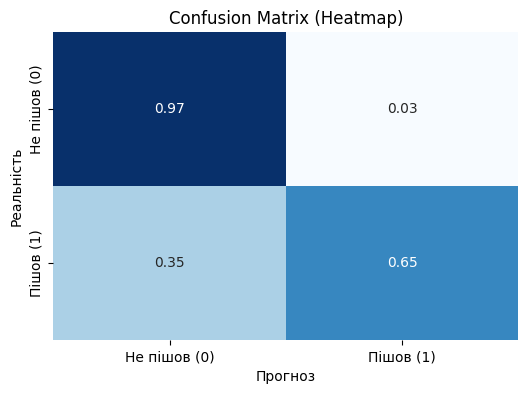

Test
F1-Score: 0.724

 Classification Report
              precision    recall  f1-score   support

          -1       0.92      0.96      0.94      2390
           1       0.81      0.66      0.72       610

    accuracy                           0.90      3000
   macro avg       0.86      0.81      0.83      3000
weighted avg       0.89      0.90      0.89      3000



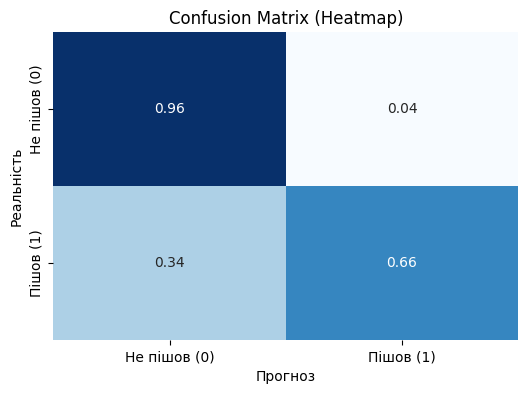

In [58]:
best_C = random_search.best_params_["C"]
best_gamma = random_search.best_params_["gamma"]

final_svm = SVC(kernel="rbf", C=best_C, gamma=best_gamma)
final_svm.fit(X_train_proc, y_train)

print("Detailed Metrics")

print("Train")
metrics(final_svm, X_train_proc, y_train)

print("Test")
metrics(final_svm, X_test_proc, y_test)

**Висновки:**
 - модель збалансована: якість на тренувальний і тестових даних майже однакова, немає ознак перенавчання;
 - гарна точність і f1: модель добре класифікує більший клас, але для меншого recall нижчий, ніж precision;
 - дисбаланс класів: метрики кращі для більшого класу;
 - macro avg і weighted avg близькі для тренувальних і тестових даних, це означає, що модель добре узагальнює.

Що можна було б покращити:

 - збалансувати класи, використати oversampling/undersampling;
 - спробувати інші ядра або інші моделі.

Detailed Metrics
Train
F1-Score: 0.734

 Classification Report
              precision    recall  f1-score   support

          -1       0.96      0.87      0.92      9558
           1       0.63      0.87      0.73      2442

    accuracy                           0.87     12000
   macro avg       0.80      0.87      0.82     12000
weighted avg       0.90      0.87      0.88     12000



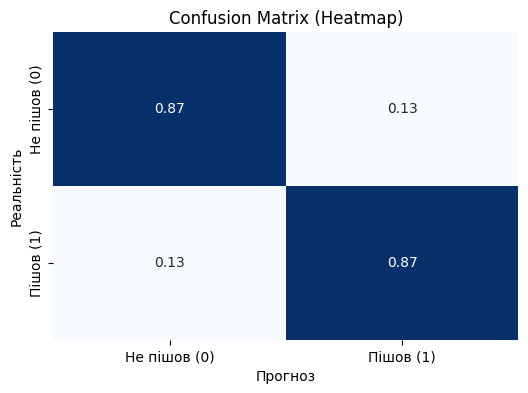

Test
F1-Score: 0.707

 Classification Report
              precision    recall  f1-score   support

          -1       0.96      0.86      0.90      2390
           1       0.60      0.86      0.71       610

    accuracy                           0.86      3000
   macro avg       0.78      0.86      0.81      3000
weighted avg       0.89      0.86      0.86      3000



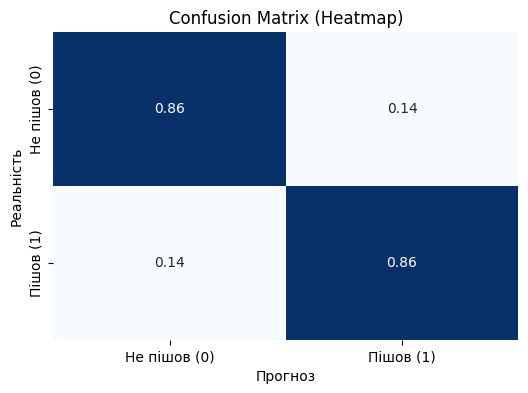

In [60]:
# Модель з балансуванням класів
svm_balanced = SVC(kernel="rbf", C=1.0, gamma=0.1, class_weight="balanced", random_state=42)

# Навчання
svm_balanced.fit(X_train_proc, y_train)

print("Detailed Metrics")

print("Train")
metrics(svm_balanced, X_train_proc, y_train)

print("Test")
metrics(svm_balanced, X_test_proc, y_test)


**Спостереження:**
 - баланс між класами покращився;
 - модель краще впізнає позитивні випадки, але ціною більшої кількості загальних помилок.

 Яка модель краще залежить від задачі:
 - якщо потрібно сфокусуватися на утриманні клієнтів, підходить модель з балансуванням класів;
 - для оптимізації витрат, не витрачати ресурси на клієнтів, які і так залишаються, то варто обрати модель без балансування, щоб зберегти високу точність прогнозів.